In [2]:
from random import randint
import matplotlib.pylab as plt 
import numpy as np
from keras import models, activations, backend, utils, Model
import matplotlib.image as mpimg
import scipy.ndimage as ndimage
import tensorflow as tf
import cv2 as cv
import pandas as pd
# from vis.visualization import visualize_saliency 
# from vis.utils import utils 

2025-05-09 13:17:46.747455: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 13:17:47.066207: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 13:17:47.066329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 13:17:47.124523: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 13:17:47.236427: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 13:17:47.238684: I tensorflow/core/platform/cpu_feature_guard.cc:1

Model: "better_than_a_tesla"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 244, 244, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 244, 244, 3)          0         ['input_2[0][0]']             
                                                                                                  
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)           3228864   ['rescaling[0][0]',           
 onal)                                                               'rescaling_1[0][0]']         
                                                                                                  
 global_average_pooling2d (  (None, 1024)                 0         ['mobilenet_

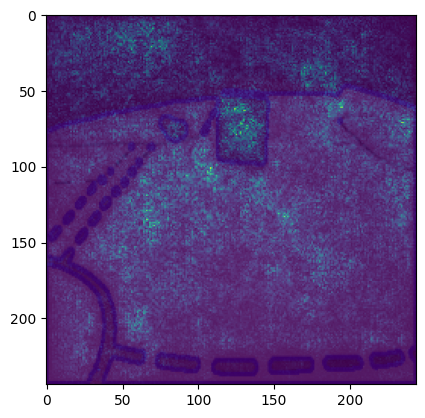

In [15]:
df = pd.read_csv(f"../../data/big_data/updated_training_norm-15452.csv")
#saved_model.summary()

def load_im_for_kaggle_version(im_pth):
    image = utils.load_img(f"../../data/big_data/training_data/training_data/{im_pth}")
    image = tf.image.resize(image, [244, 244])
    image = tf.expand_dims(image, axis=0)
    return image

def load_im_for_picar_version(im_pth):
    image_colour = cv.imread(f"../../data/big_data/training_data/training_data/{im_pth}")
    image = cv.cvtColor(image_colour, cv.COLOR_BGR2GRAY)
    image = cv.medianBlur(image,5)
    ret,threshold = cv.threshold(image,127,255,cv.THRESH_BINARY)
    contours, heirarchy = cv.findContours(threshold, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(image_colour, contours, -1, (0,0,255), 2)
    image_colour = cv.resize(image_colour, (244,244))
    image_colour = np.expand_dims(image_colour, axis=0).astype(np.float32)
    
    return tf.convert_to_tensor(image_colour)

def find_class_label(im_label):
    categories_angle = [0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0]
    
    row = df[df['image_id'] == im_label]
    angle, speed = row[['angle', 'speed']].values[0]
    
    return categories_angle.index(angle), int(speed)
    
def get_saliency_map(model, image, class_idx, model_type, pred_type):
    #vanilla gradient saliency 
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image)
        
        if model_type == 'multi_head':
            if pred_type == 'speed':
                loss = predictions[0][:, class_idx]
            else: 
                loss = predictions[0][:, class_idx]
        else: 
             loss = predictions[:, class_idx]   
        
    
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image)
    
    #get the absolute value 
    gradient = tf.abs(gradient)
    
    # take maximum across channels
    gradient = tf.reduce_max(gradient, axis=-1)
    
    # convert to numpy
    gradient = gradient.numpy()
    
    # normaliz between 0 and 1
    min_val, max_val = np.min(gradient), np.max(gradient)
    smap = (gradient - min_val) / (max_val - min_val + backend.epsilon())
    #smap = cv.medianBlur(smap,5)   
    
    #print(smap)
    return smap


def show_saliency_overlay(im_label, model_type, pred_type):
    
    model_types = {
        'angle' : "model_angle.h5", 
        'speed' : "model_speed.h5",
        'multi_head' : "multi_head_model_class_V2.h5"}
    
    model_name = model_types[model_type]
    saved_model = models.load_model(f"../../models/{model_name}")
    saved_model.summary()
    class_labels = find_class_label(im_label)
    class_idx = class_labels[1] if pred_type == 'speed' else class_labels[0]
    print(class_idx)
    if model_type == 'multi_head':
        image = load_im_for_picar_version(f"{im_label}.png")
    else: 
        image = load_im_for_kaggle_version(f"{im_label}.png")

    
    saliency_map = get_saliency_map(saved_model, image, class_idx, model_type, pred_type)

    plt.imshow(image[0].numpy().astype(np.uint8))
    plt.imshow(saliency_map[0], alpha=.9)
   
show_saliency_overlay(182, 'multi_head', 'speed')

In [13]:
saved_model = models.load_model(f"../../models/model_regression.h5")
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 244, 244, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 640)               656000    
                                                                 
 dropout (Dropout)           (None, 640)               0         
                                                                 
 batch_normalization (Batch  (None, 640)               2

In [68]:
import seaborn as sns
sns.set_theme()
plt.rcParams['font.family'] = 'Georgia'

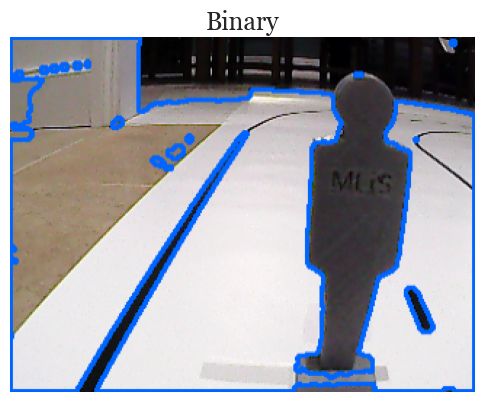

In [82]:
image_colour = cv.imread("../../data/training_data/training_data/20.png")
image = cv.cvtColor(image_colour, cv.COLOR_BGR2GRAY)
image = cv.medianBlur(image, 5)
ret, threshold = cv.threshold(image, 127, 255, cv.THRESH_BINARY)

contours, hierarchy = cv.findContours(threshold, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(image_colour, contours, -1, (255, 100, 0), 2)

image_colour = cv.resize(image_colour, (320, 244))
image_rgb = cv.cvtColor(image_colour, cv.COLOR_BGR2RGB)


fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(image_rgb)
ax.axis('off') 
ax.set_title('Binary', fontsize=18)

plt.savefig('img/saliency_binary.png', dpi=300, bbox_inches='tight')
plt.show()

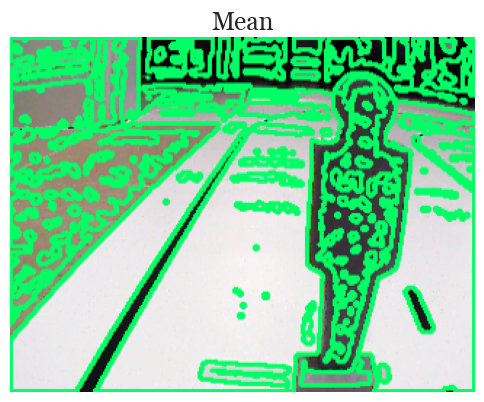

In [76]:
image_colour = cv.imread("../../data/training_data/training_data/20.png")
image = cv.cvtColor(image_colour, cv.COLOR_BGR2GRAY)
image = cv.medianBlur(image, 5)
ret, threshold = cv.threshold(image, 127, 255, cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)

contours, hierarchy = cv.findContours(th2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(image_colour, contours, -1, (100, 255, 0), 2)

image_colour = cv.resize(image_colour, (320, 244))
image_rgb = cv.cvtColor(image_colour, cv.COLOR_BGR2RGB)


fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(image_rgb)
ax.axis('off') 
ax.set_title('Mean', fontsize=18)

plt.savefig('img/saliency_mean.png', dpi=300, bbox_inches='tight')
plt.show()

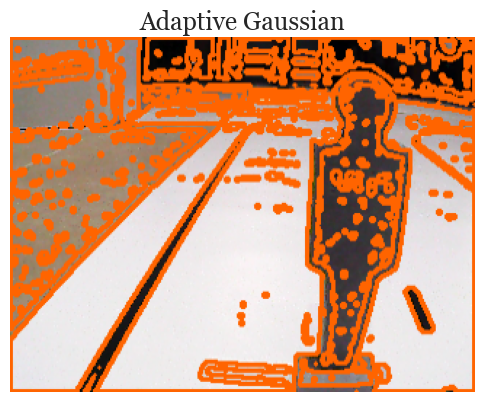

In [78]:
image_colour = cv.imread("../../data/training_data/training_data/20.png")
image = cv.cvtColor(image_colour, cv.COLOR_BGR2GRAY)
image = cv.medianBlur(image, 5)
ret, threshold = cv.threshold(image, 127, 255, cv.THRESH_BINARY)
th3 = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)

contours, hierarchy = cv.findContours(th3, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(image_colour, contours, -1, (0, 100, 255), 2)

image_colour = cv.resize(image_colour, (320, 244))
image_rgb = cv.cvtColor(image_colour, cv.COLOR_BGR2RGB)


fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(image_rgb)
ax.axis('off') 
ax.set_title('Adaptive Gaussian', fontsize=18)

plt.savefig('img/saliency_adaptiveGaussian.png', dpi=300, bbox_inches='tight')
plt.show()